In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.123285,0.093923,0.124080,0.112708,0.112708,0.280549
1,0.083119,0.054180,0.108808,0.090008,0.090008,0.296007
2,0.022265,0.055572,0.079545,0.089628,0.089628,0.337838
3,0.109713,0.105948,0.155523,0.160459,0.160459,0.217824
4,0.142359,0.141421,0.181922,0.188066,0.188066,0.166670


In [4]:
def layer_normalization(x, epsilon=1e-8):
    shape = x.get_shape()
    tf.Variable(tf.zeros(shape = [int(shape[-1])]))
    beta = tf.Variable(tf.zeros(shape = [int(shape[-1])]))
    gamma = tf.Variable(tf.ones(shape = [int(shape[-1])]))
    mean, variance = tf.nn.moments(x, axes=[len(shape) - 1], keep_dims=True)
    x = (x - mean) /  tf.sqrt(variance + epsilon)
    return gamma * x + beta

def conv1d(input_, output_channels, dilation = 1, filter_width = 1, causal = False):
    w = tf.Variable(tf.random_normal([1, filter_width, int(input_.get_shape()[-1]), output_channels], stddev = 0.02))
    b = tf.Variable(tf.zeros(shape = [output_channels]))
    if causal:
        padding = [[0, 0], [(filter_width - 1) * dilation, 0], [0, 0]]
        padded = tf.pad(input_, padding)
        input_expanded = tf.expand_dims(padded, dim = 1)
        out = tf.nn.atrous_conv2d(input_expanded, w, rate = dilation, padding = 'VALID') + b
    else:
        input_expanded = tf.expand_dims(input_, dim = 1)
        out = tf.nn.atrous_conv2d(input_expanded, w, rate = dilation, padding = 'SAME') + b
    return tf.squeeze(out, [1])

def bytenet_residual_block(input_, dilation, layer_no, 
                            residual_channels, filter_width, 
                            causal = True):
    block_type = "decoder" if causal else "encoder"
    block_name = "bytenet_{}_layer_{}_{}".format(block_type, layer_no, dilation)
    with tf.variable_scope(block_name):
        relu1 = tf.nn.relu(layer_normalization(input_))
        conv1 = conv1d(relu1, residual_channels)
        relu2 = tf.nn.relu(layer_normalization(conv1))
        dilated_conv = conv1d(relu2, residual_channels, 
                              dilation, filter_width,
                              causal = causal)
        print(dilated_conv)
        relu3 = tf.nn.relu(layer_normalization(dilated_conv))
        conv2 = conv1d(relu3, 2 * residual_channels)
        return input_ + conv2
    
class ByteNet:
    def __init__(self, size, output_size, channels, encoder_dilations, encoder_filter_width,
                learning_rate = 0.001, beta1=0.5):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        embedding_channels = 2 * channels
        curr_input = tf.layers.dense(self.X, embedding_channels)
        curr_input = tf.nn.dropout(curr_input, keep_prob = 0.75)
        for layer_no, dilation in enumerate(encoder_dilations):
            curr_input = bytenet_residual_block(curr_input, dilation, 
                                                layer_no, channels, 
                                                encoder_filter_width, 
                                                causal = False)
        encoder_output = curr_input
        self.logits = tf.layers.dense(encoder_output[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [5]:
timestamp = 5
epoch = 500
future_day = 50
residual_channels = 128
encoder_dilations = [1,2,4,8,16,1,2,4,8,16]
encoder_filter_width = 3

In [6]:
tf.reset_default_graph()
modelnn = ByteNet(df_log.shape[1], df_log.shape[1], residual_channels,
                encoder_dilations, encoder_filter_width)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use the `axis` argument instead
Tensor("bytenet_encoder_layer_0_1/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_1_2/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_2_4/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_3_8/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_4_16/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_5_1/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_6_2/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_7_4/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_8_8/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)
Tensor("bytenet_encoder_layer_9_16/Squeeze_1:0", shape=(?, ?, 128), dtype=float32)


In [7]:
for i in range(epoch):
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] -1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        _, loss = sess.run(
            [modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y
            },
        )
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.0027568807604257018
epoch: 200 avg loss: 0.0027120405476307495
epoch: 300 avg loss: 0.002129034238460008
epoch: 400 avg loss: 0.0014129470387706533
epoch: 500 avg loss: 0.0016491042880807073


In [8]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits = sess.run(modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp, :], axis = 0
            )
        },
    )
    output_predict[k + 1 : k + timestamp + 1, :] = out_logits

out_logits = sess.run(modelnn.logits,
    feed_dict = {modelnn.X: np.expand_dims(df_log.iloc[upper_b:, :], axis = 0)},
)
output_predict[upper_b + 1 : df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [9]:
for i in range(future_day - 1):
    out_logits = sess.run(modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0)
        },
    )
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [10]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [11]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

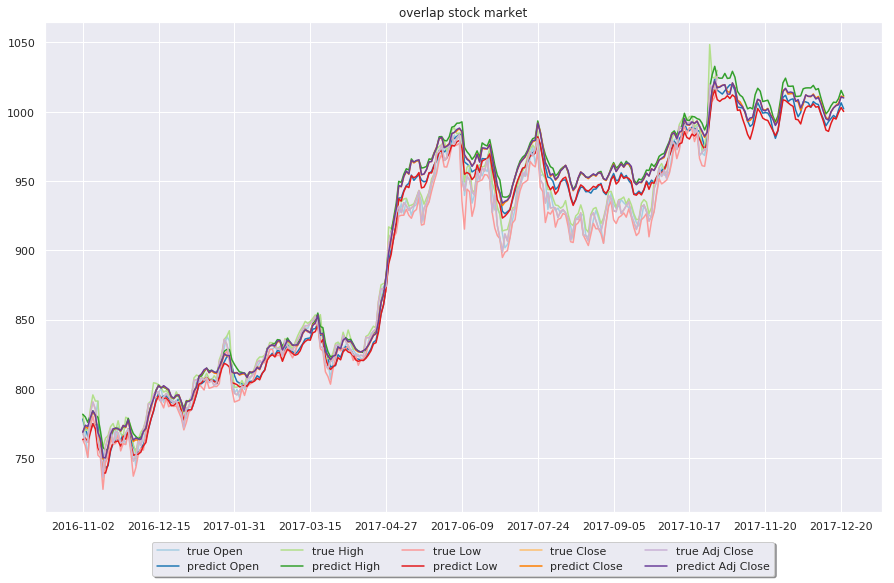

In [12]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

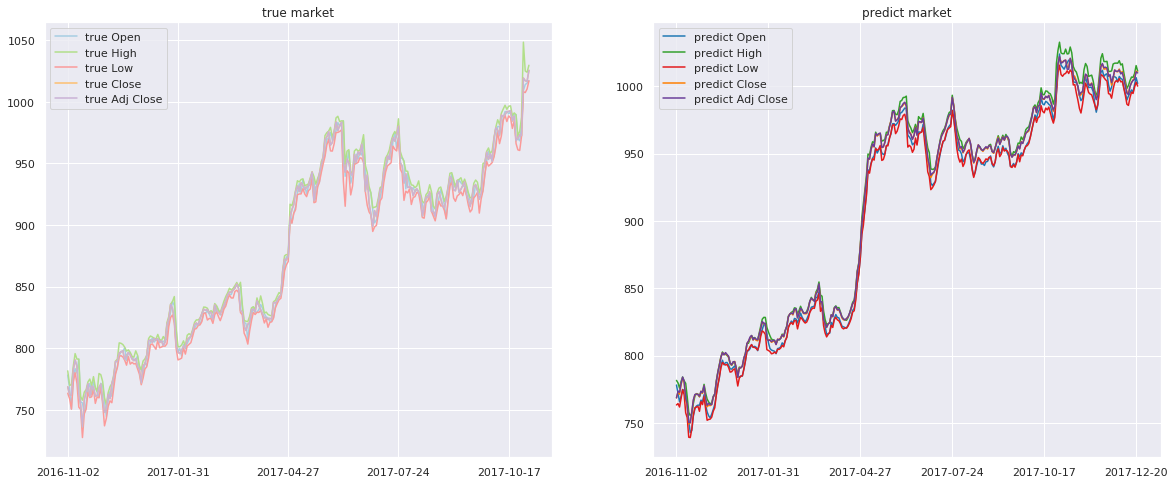

In [13]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

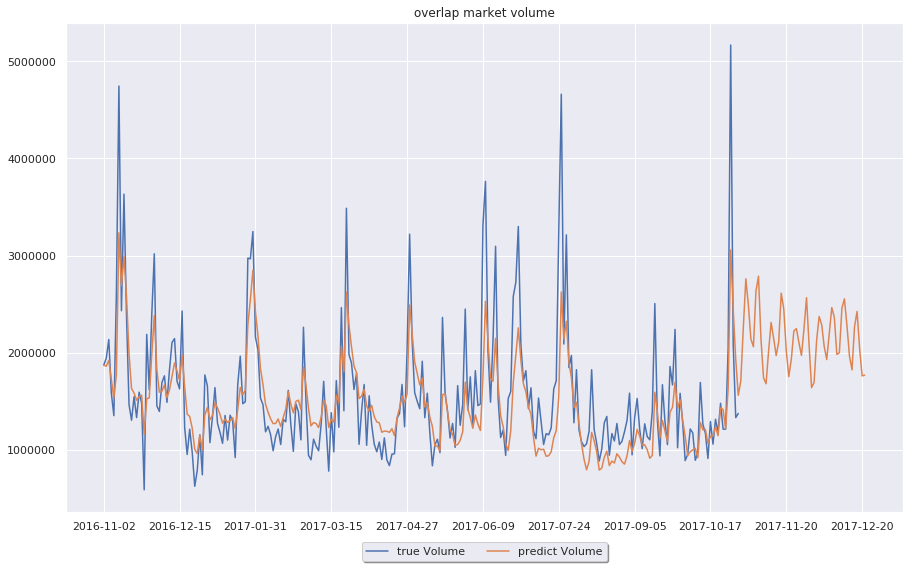

In [14]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()